# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2019-10-07 23:59:13,974 INFO    : root         : Using LISA logging configuration:
2019-10-07 23:59:13,977 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2019-10-07 23:59:14,214 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2019-10-07 23:59:14,228 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

## Defines

In [5]:
#file_name = 'G9750/com.eg.android.AlipayGphone_1.html'
file_name = 'com.eg.android.AlipayGphone_3.html'

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnQTAxNUYvQlNQLUFTVFJPJywgbGF5b3V0PUxheW91dCh3aWR0aD11JzIwMCUnKSwgc3R5bGU9RGVzY3LigKY=


## Run cells

In [11]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [12]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

## Read Files

In [13]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing G975U_P_TEST.html - 339042 lines are Ok
Parsing G975U_Q_TEST.html - 215841 lines are Ok


## Analysis

### The timing of marking data

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

G975U_GLPreloading_G975U_P_TEST


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1604.0,NaN,1.298,0.505,NaN,NaN,NaN,NaN,NaN
1605.0,NaN,0.548,0.307,NaN,NaN,NaN,NaN,NaN
1194.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.758
3212.0,NaN,0.249,0.709,NaN,NaN,NaN,NaN,NaN
1839.0,NaN,15.267,0.535,NaN,NaN,NaN,NaN,NaN
4272.0,0.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16116.0,10.765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1796.0,0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4027.0,0.591,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

G975U_GLPreloading_G975U_Q_TEST


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.739
15361.0,1.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29126.0,12.379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5197.0,NaN,12.580,3.957,NaN,NaN,NaN,NaN,NaN
7950.0,NaN,0.057,0.410,NaN,NaN,NaN,NaN,NaN
29105.0,NaN,25.867,0.474,21.788,41.505,19.331,8.784,NaN
15538.0,NaN,4.177,NaN,NaN,NaN,NaN,NaN,NaN
15608.0,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1147.0,NaN,6.689,0.896,NaN,NaN,NaN,NaN,NaN


### Launching Time(AVERAGE)

In [17]:
list_of_df = group1.get_marking_time()
count1 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        count1 += 1
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

sum_df1 = DataFrame(sum_df1.sum(axis=0)).swapaxes("index", "columns") 
sum_df1.index = [group1.title]
sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1)


list_of_df = group2.get_marking_time()
count2 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        count2 += 1
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching
        
sum_df2 = DataFrame(sum_df2.sum()).swapaxes("index", "columns") 
sum_df2.index = [group2.title]
sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1)

pd.concat([sum_df1 * 1000 / count1, sum_df2 * 1000 / count2])

,launching
G975U_GLPreloading_G975U_P_TEST,109.758
G975U_GLPreloading_G975U_Q_TEST,123.739


### Process Time(AVERAGE)

In [18]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
G975U_GLPreloading_G975U_P_TEST time                                0   
                                RUNNING                             0   
                                RUNNABLE                            0   
                                SLEEPING                            0   
                                UNINTERUPTIBLE_SLEEP                0   
                                UNINTERUPTIBLE_SLEEP(I/O)           0   
G975U_GLPreloading_G975U_Q_TEST time                                0   
                                RUNNING                             0   
                                RUNNABLE                            0   
                                SLEEPING                            0   
                                UNINTERUPTIBLE_SLEEP                0   
                                UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                            time                                0   
                                RUNNING                             0   
                                RUNNABLE                            0   
                                SLEEPING                            0   
                                UNINTERUPTIBLE_SLEEP                0   
                                UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                           Choreographer #0  \
G975U_GLPreloading_G975U_P_TEST time                                 14.643   
                                RUNNING                               7.044   
                                RUNNABLE                              0.116   
                                SLEEPING                              7.434   
                                UNINTERUPTIBLE_SLEEP                  0.049   
                                UNINTERUPTIBLE_SLEEP(I/O)             0.000   
G975U_GLPreloading_G975U_Q_TEST time                                 25.867   
                                RUNNING                               3.985   
                                RUNNABLE                              0.605   
                                SLEEPING                             21.267   
                                UNINTERUPTIBLE_SLEEP                  0.010   
                                UNINTERUPTIBLE_SLEEP(I/O)             0.000   
DIFF                            time                                -11.224   
                                RUNNING                               3.059   
                                RUNNABLE                             -0.489   
                                SLEEPING                            -13.833   
                                UNINTERUPTIBLE_SLEEP                  0.039   
                                UNINTERUPTIBLE_SLEEP(I/O)             0.000   

                                                           Choreographer #1  \
G975U_GLPreloading_G975U_P_TEST time                                 12.018   
                                RUNNING                               1.000   
                                RUNNABLE                              0.028   
                                SLEEPING                             10.990   
                                UNINTERUPTIBLE_SLEEP                  0.000   
                                UNINTERUPTIBLE_SLEEP(I/O)             0.000   
G975U_GLPreloading_G975U_Q_TEST time                                  0.474   
                                RUNNING                               0.191   
                                RUNNABLE                              0.006   
                                SLEEPING                              0.277   
                                UNINTERUPTIBLE_SLEEP                  0.000   
                                UNINTERUPTIBLE_SLEEP(I/O)             0.000   
DIFF                            time                                 11.544   
                                RUNNING                        

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
G975U_GLPreloading_G975U_P_TEST,time,0,14.643,12.018,12.587,38.055,7.354,10.916,0
G975U_GLPreloading_G975U_Q_TEST,time,0,25.867,0.474,21.788,41.505,19.331,8.784,0
DIFF,time,0,-11.224,11.544,-9.201,-3.450,-11.977,2.132,0


### Processing time of setSurface

In [19]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [20]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,avg
G975U_GLPreloading_G975U_P_TEST,10.765,10.765
G975U_GLPreloading_G975U_Q_TEST,12.379,12.379


### Uninterruptible Sleep

In [21]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

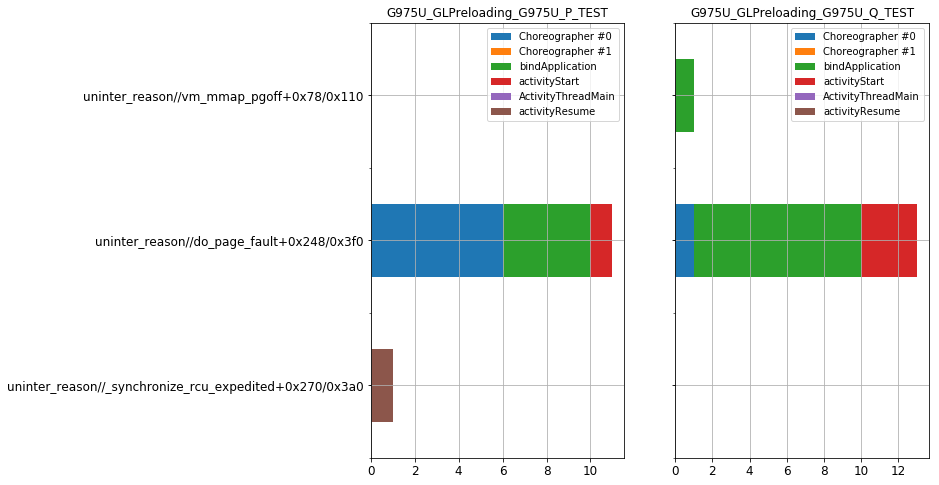

In [22]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

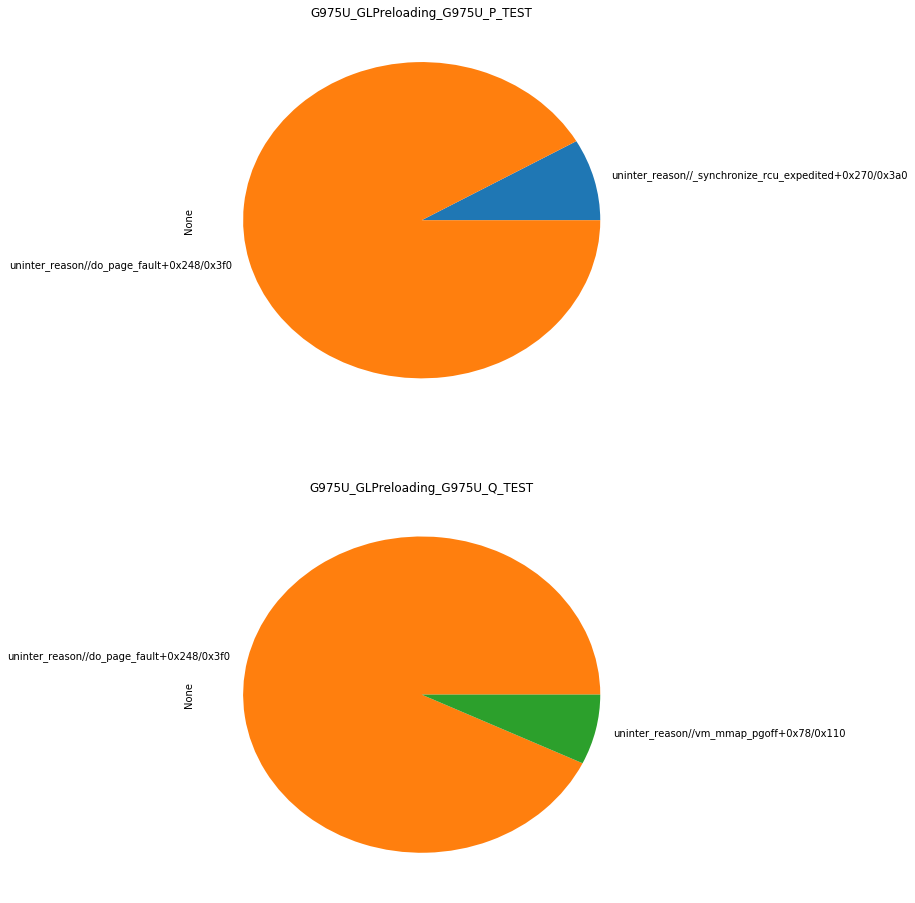

In [23]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

### Number of Running Cores(SUM)

Choreographer #0  Choreographer #1  \
G975U_GLPreloading_G975U_P_TEST core0                 0                 0   
                                core1                 0                 0   
                                core2                 0                 0   
                                core3                 0                 0   
                                core4                 4                 0   
                                core5                 3                 0   
                                core6                 6                 0   
                                core7                 5                 3   
G975U_GLPreloading_G975U_Q_TEST core0                 0                 0   
                                core1                 0                 0   
                                core2                 0                 0   
                                core3                 0                 0   
                                core4                 7                 0   
                                core5                 2                 1   
                                core6                 1                 0   
                                core7                 0                 0   

                                       bindApplication  activityStart  \
G975U_GLPreloading_G975U_P_TEST core0                0              0   
                                core1                0              0   
                                core2                0              0   
                                core3                0              0   
                                core4                3             16   
                                core5                0              9   
                                core6               14              4   
                                core7                0              5   
G975U_GLPreloading_G975U_Q_TEST core0                0              0   
                                core1                0              0   
                                core2                0              0   
                                core3                0              0   
                                core4                1             20   
                                core5               22             12   
                                core6                9              6   
                                core7                0              4   

                                       ActivityThreadMain  activityResume  
G975U_GLPreloading_G975U_P_TEST core0                   0               0  
                                core1                   0               0  
                                core2                   0               0  
                                core3                   0               0  
                                core4                   0               6  
                                core5                   0               6  
                                core6                   3               0  
                                core7                   0              10  
G975U_GLPreloading_G975U_Q_TEST core0                   0               0  
                                core1                   0               0  
                                core2                   0               0  
                                core3                   0               0  
                                core4                   0              11  
                                core5                   0               4  
                                core6                   4               2  
                                core7                   0               0

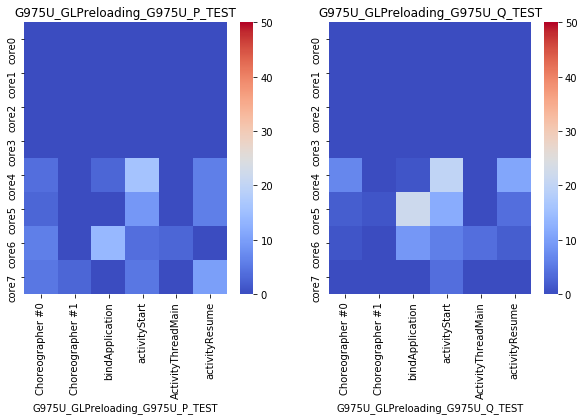

In [24]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [25]:
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,0,0,0,NaN
core1,NaN,0,0,0,0,0,0,NaN
core2,NaN,0,0,0,0,0,0,NaN
core3,NaN,0,0,0,0,0,0,NaN
core4,NaN,4,0,3,16,0,6,NaN
core5,NaN,3,0,0,9,0,6,NaN
core6,NaN,6,0,14,4,3,0,NaN
core7,NaN,5,3,0,5,0,10,NaN


In [26]:
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,0,0,0,NaN
core1,NaN,0,0,0,0,0,0,NaN
core2,NaN,0,0,0,0,0,0,NaN
core3,NaN,0,0,0,0,0,0,NaN
core4,NaN,7,0,1,20,0,11,NaN
core5,NaN,2,1,22,12,0,4,NaN
core6,NaN,1,0,9,6,4,2,NaN
core7,NaN,0,0,0,4,0,0,NaN


In [40]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [41]:
display(GetCoreStats(group1))

0  1  2  3  4  5  6  7  selected         time
ActivityThreadMain 0   I  I  I  I  I  I  V  I         6  1242.712684
                   1   I  R  I  I  I  I  V  I         6  1242.713616
                   2   R  R  R  I  I  I  V  I         6  1242.717488
bindApplication    0   R  I  I  I  I  I  V  I         6  1242.721430
                   1   R  R  I  I  R  I  V  I         6  1242.721672
                   2   R  I  I  R  I  I  V  I         6  1242.721751
                   3   R  I  I  R  R  I  V  I         6  1242.721783
                   4   I  R  R  R  I  I  V  I         6  1242.722167
                   5   R  I  R  I  I  I  V  I         6  1242.722842
                   6   R  I  I  I  I  I  V  I         6  1242.723029
                   7   I  I  I  R  I  I  V  I         6  1242.723929
                   8   I  R  I  R  I  I  V  I         6  1242.724195
                   9   I  I  I  I  I  I  V  I         6  1242.725544
                   10  I  I  I  I  I  I  V  I         6  1242.725989
                   11  I  I  I  I  I  I  V  I         6  1242.726089
                   12  R  I  R  I  I  I  V  I         6  1242.727342
                   13  I  I  I  I  V  I  I  I         4  1242.732174
                   14  I  I  I  I  V  I  I  I         4  1242.732753
                   15  I  I  I  I  V  I  I  I         4  1242.733198
                   16  I  I  I  I  V  I  I  I         4  1242.733769
activityStart      0   I  I  I  I  I  V  R  R         5  1242.843361
                   1   I  I  I  R  I  V  R  I         5  1242.843885
                   2   I  I  I  R  V  I  R  I         4  1242.844974
                   3   I  R  I  R  V  I  R  I         4  1242.845021
                   4   I  I  I  R  R  I  V  I         6  1242.851592
                   5   R  I  I  R  I  I  V  I         6  1242.852249
                   6   R  I  I  R  V  I  I  I         4  1242.852492
                   7   I  I  I  I  V  I  I  R         4  1242.853201
                   8   R  I  R  I  I  R  I  V         7  1242.854757
                   9   R  I  I  I  V  R  I  I         4  1242.856205
                   10  R  I  I  R  R  R  I  V         7  1242.856596
                   11  I  R  I  I  I  I  I  V         7  1242.858479
                   12  I  I  I  I  V  I  I  I         4  1242.858887
                   13  I  R  I  I  V  I  I  R         4  1242.859158
                   14  I  R  I  I  V  I  I  I         4  1242.859702
                   15  R  R  R  I  R  I  V  R         6  1242.870603
                   16  R  I  I  I  I  I  V  R         6  1242.871211
                   17  R  R  I  I  V  I  I  I         4  1242.871424
                   18  R  I  I  I  I  V  I  I         5  1242.871572
                   19  R  I  I  I  V  I  I  I         4  1242.871757
                   20  R  I  I  I  R  V  I  I         5  1242.871896
                   21  R  R  I  R  I  R  I  V         7  1242.872293
                   22  R  I  R  I  I  V  I  I         5  1242.872468
                   23  I  I  I  R  V  I  I  R         4  1242.872976
                   24  I  I  I  I  I  V  I  I         5  1242.876928
                   25  I  I  I  I  V  I  I  I         4  1242.877135
                   26  I  I  R  I  I  V  I  I         5  1242.878029
                   27  I  I  I  I  V  I  I  I         4  1242.878623
                   28  I  R  R  I  I  I  I  V         7  1242.878986
                   29  I  I  I  I  V  I  I  I         4  1242.879392
                   30  I  I  R  I  V  I  I  I         4  1242.879601
                   31  R  R  R  I  I  V  I  I         5  1242.879982
                   32  I  I  I  I  V  I  I  I         4  1242.880929
                   33  I  I  I  I  I  V  I  I         5  1242.881160
activityResume     0   I  I  I  I  I  V  I  I         5  1242.881541
                   1   I  I  I  I  V  I  I  I         4  1242.882529
                   2   R  I  I  I  I  I  I  V         7  1242.883164
                   3 

In [42]:
display(GetCoreStats(group2))

0  1  2  3  4  5  6  7  selected         time
ActivityThreadMain 0   I  R  I  R  I  I  V  I         6  1596.134429
                   1   I  R  I  R  I  I  V  I         6  1596.134746
                   2   I  I  I  I  R  I  V  I         6  1596.135415
                   3   R  I  I  R  R  V  I  I         5  1596.151749
bindApplication    0   I  I  I  R  I  V  I  I         5  1596.153395
                   1   I  I  I  R  I  V  I  I         5  1596.153612
                   2   R  I  R  I  I  V  I  I         5  1596.154317
                   3   I  I  R  I  I  V  R  R         5  1596.154537
                   4   I  I  I  I  R  V  R  I         5  1596.155412
                   5   I  R  R  R  I  V  I  I         5  1596.155757
                   6   I  I  I  I  I  V  I  I         5  1596.156646
                   7   R  I  I  I  R  V  I  R         5  1596.166605
                   8   I  I  I  R  R  V  R  R         5  1596.167637
                   9   I  I  I  R  R  V  R  R         5  1596.167662
                   10  I  I  I  R  I  V  R  R         5  1596.167687
                   11  I  I  R  R  R  V  R  R         5  1596.167831
                   12  I  I  I  R  R  V  I  R         5  1596.167964
                   13  I  R  I  I  R  V  I  R         5  1596.168541
                   14  I  R  I  I  R  V  I  R         5  1596.169169
                   15  I  R  I  R  R  V  R  R         5  1596.169356
                   16  I  R  I  I  I  V  I  R         5  1596.169380
                   17  I  R  I  I  I  V  R  R         5  1596.169491
                   18  I  R  I  I  I  V  R  R         5  1596.169533
                   19  I  R  I  I  I  V  R  I         5  1596.169578
                   20  I  I  I  I  I  V  R  I         5  1596.169645
                   21  I  I  R  R  I  R  V  I         6  1596.172146
                   22  I  I  I  R  I  R  V  I         6  1596.172289
                   23  I  I  R  I  I  R  V  I         6  1596.172446
                   24  I  I  R  I  I  R  V  I         6  1596.172537
                   25  I  I  I  I  I  R  V  I         6  1596.172590
                   26  I  I  R  I  I  R  V  I         6  1596.173219
                   27  I  I  I  I  I  I  V  I         6  1596.173425
                   28  I  I  I  I  I  I  V  I         6  1596.173619
                   29  I  I  I  I  I  R  V  I         6  1596.173942
                   30  I  I  R  I  V  R  I  I         4  1596.174538
                   31  I  I  R  I  I  I  V  I         6  1596.174663
activityStart      0   I  I  I  I  I  I  V  I         6  1596.175029
                   1   I  I  R  R  I  R  V  I         6  1596.175732
                   2   R  I  I  I  I  I  V  I         6  1596.176179
                   3   I  I  I  I  I  V  I  R         5  1596.176688
                   4   I  I  I  I  I  V  I  R         5  1596.176754
                   5   I  I  I  I  I  V  I  I         5  1596.176837
                   6   I  I  I  R  I  V  I  R         5  1596.177050
                   7   I  R  I  I  V  I  I  I         4  1596.189968
                   8   I  R  I  I  V  I  I  I         4  1596.191214
                   9   I  R  I  I  V  I  I  I         4  1596.191463
                   10  I  R  R  R  V  R  I  I         4  1596.192845
                   11  I  I  R  R  V  R  I  R         4  1596.193649
                   12  I  I  R  I  V  R  I  R         4  1596.193994
                   13  I  I  I  I  V  I  I  I         4  1596.194907
                   14  I  I  I  I  V  I  I  I         4  1596.195499
                   15  I  I  R  R  V  I  I  R         4  1596.196477
                   16  I  I  R  R  V  R  I  R         4  1596.196615
                   17  I  I  R  R  V  I  I  I         4  1596.197849
                   18  I  R  I  I  I  I  V  I         6  1596.199172
                   19  I  R  I  R  I  I  V  I         6  1596.199746
                   20  I  R  I  I  I  I  R  V         7  1596.200822
                   21

### Cpu Frequency

In [30]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

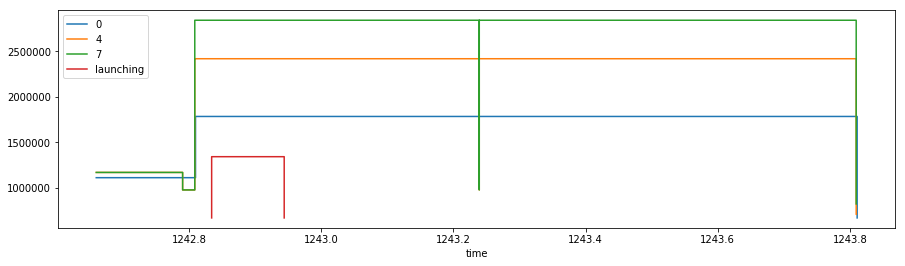

In [31]:
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

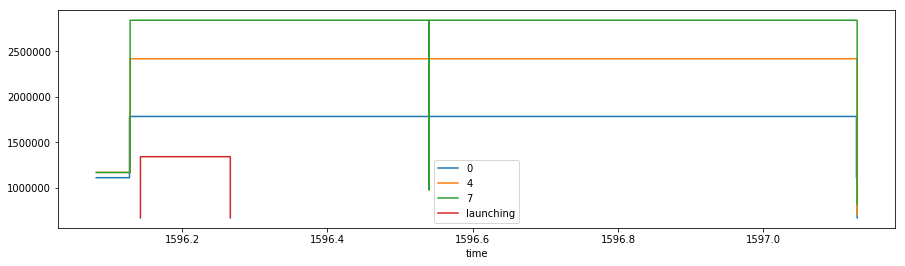

In [32]:
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

In [33]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

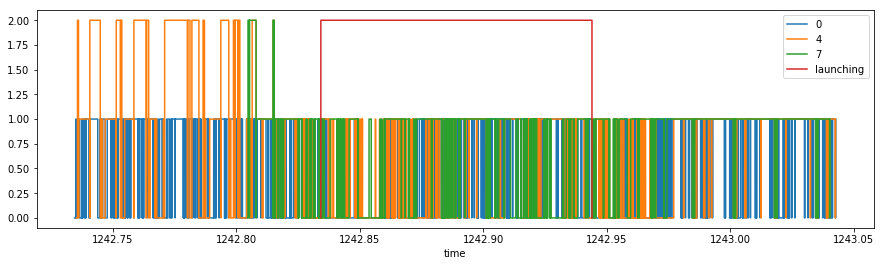

In [34]:
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

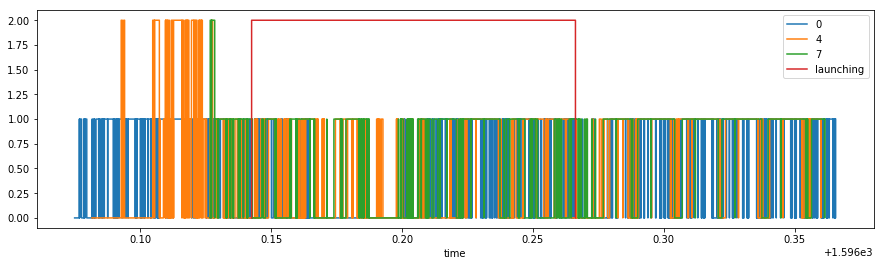

In [35]:
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [36]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
W2020_W2020 SJ5_taobao_trace,lock_contention,0,3.628,42.985,287.866,62.910,7.112,5.706,0
W2020_huawei_P30_Pro_taobao_trace_1st,lock_contention,0,0.000,29.040,227.822,17.476,4.736,16.594,0
DIFF,lock_contention,0,3.628,13.945,60.044,45.434,2.376,-10.888,0


In [37]:
def DrawLockContention(group, value='NaN'):
    for parser in group.parsers_of_testing:
        for lock_contention in parser.storage_lock_contention:
            lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
            lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
        df = DataFrame.from_dict(parser.storage_lock_contention)
        df.loc[df['duration'] > 0, 'duration'] *= 1000

        if value == 'NaN':
            display(df.sort_values(by=['duration'], ascending=False))
        else:
            display(DataFrame(df[value].value_counts()))

In [38]:
DrawLockContention(group1)

,blocking,context,duration,effection,owner,pid,time,type
232,void com.taobao.orange.ConfigCenter$12.run()(...,monitor contention with owner Orange:0 (15047)...,506.854,NaN,Orange:0 (15047) at boolean java.util.regex.Ma...,15154,503.880927,B
127,java.lang.Object com.alibaba.wireless.securit...,monitor contention with owner MTOPSDK DefaultP...,98.708,NaN,MTOPSDK DefaultPool Thread:1 (15011) at java.i...,15014,503.069852,B
163,void com.taobao.alivfssdk.fresco.cache.disk.b...,monitor contention with owner bootimage pre-In...,55.937,O,bootimage pre-Init (14987) at java.security.Me...,15082,503.371545,B
131,boolean mtopsdk.mtop.intf.Mtop.checkMtopSDKIn...,monitor contention with owner MTOPSDK DefaultP...,39.878,NaN,MTOPSDK DefaultPool Thread:1 (15011) at java.l...,15027,503.142461,B
74,void com.android.server.am.ActivityRecord.onS...,monitor contention with owner android.ui (1524...,18.742,NaN,android.ui (1524) at java.util.List com.androi...,1538,502.768870,B
340,"void tb.inz.a(java.util.List, tb.ioa)(Taobao:-1)",monitor contention with owner tb.inz$1@cf09748...,18.554,O,tb.inz$1@cf09748 (15081) at char[] java.lang.S...,15061,504.451773,B
218,void com.android.server.am.ActivityStackSuper...,monitor contention with owner Binder:1417_1B (...,18.483,NaN,Binder:1417_1B (8686) at void com.android.serv...,1523,503.777939,B
219,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1417_1B (...,18.100,NaN,Binder:1417_1B (8686) at void com.android.serv...,1524,503.779288,B
72,boolean com.android.server.am.VrController.on...,monitor contention with owner android.ui (1524...,17.569,NaN,android.ui (1524) at void com.android.server.a...,1523,502.768697,B
199,void java.lang.Runtime.loadLibrary0(java.lang...,monitor contention with owner WeexJSBridgeThre...,17.059,O,WeexJSBridgeThread (14969) at void java.lang.R...,15119,503.534439,B
